# 分子のシミュレーション

Kifumi Numata (Aug 03, 2022)

In [15]:
!pip install pyscf

You should consider upgrading via the '/Applications/anaconda3/envs/qiskit/bin/python -m pip install --upgrade pip' command.


上のセルの"#"を削除して、実行した後、「Kernel」→「Restart Kernel」でカーネルの再起動をします。その後、次のセルから実行します。

In [16]:
import warnings
warnings.filterwarnings("ignore")

## Step 1: 水素分子の構造を定義する
このチュートリアルでは、水素分子(H$_2$)を使います。

<img src="h2.png"/>


まず最初に行うことは、各原子核の位置を固定します。pythonの原子核のリストとして指定し、各原子核（リスト）には、原子の種類に対応した文字列とその3次元座標（別のリスト）が含まれます。また、全体の電荷を指定すると、その電荷を生成するために必要な電子の数をQiskitが自動的に計算します。

In [17]:
from qiskit_nature.drivers import UnitsType, Molecule
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)

原子核の位置が固定されると（原子核-原子核間の力は一時的に無関係になり）、Qiskit は相互作用する電子-電子間のエネルギーの式(ハミルトニアン)を生成します。

ここでは、電子のエネルギー式(ハミルトニアン)を計算するための古典的な化学のコードとのインターフェースとなる「ドライバー」を指定します。

In [18]:
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

In [19]:
properties = driver.run()

# 電子の数と電子のスピン軌道の数が計算されます。
num_particles= properties.get_property("ParticleNumber").num_particles
num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
print(num_particles, num_spin_orbitals)

(1, 1) 4


## Step 2: 電子の運動のエネルギーの式を作る

QiskitにはElectronicStructureProblemという便利なクラスがあり、電子のハミルトニアンを構築するためにドライバーを呼び出します。

In [20]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
es_problem = ElectronicStructureProblem(driver)

ここでは、電子(フェルミオン：フェルミオンとは、電子の振る舞いを表す言葉です)のハミルトニアン（フェルミ演算子によるハミルトニアン）の作成を進めるように指示しています。

In [21]:
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3  ...


## Step 3: エネルギー式を量子ゲートに変換

量子コンピューターは量子ビットで作られているため、このフェルミ演算子のハミルトニアンを量子ビット演算子に変換する必要があります。フェルミ演算子から量子ビット演算子への変換器は複数あります。色々な変換器を試すことができますが、ここでは、量子ビットが電子のスピン軌道を表現するというシンプルな関係性を持つJordanWignerMapperを使います。

以下で、フェルミ演算子によるハミルトニアンをパウリ演算子に変換します。

In [22]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
qubit_converter = QubitConverter(JordanWignerMapper())

qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

0.04523279994605781 * YYYY
+ 0.04523279994605781 * XXYY
+ 0.04523279994605781 * YYXX
+ 0.04523279994605781 * XXXX
- 0.8105479805373281 * IIII
- 0.22575349222402358 * ZIII
+ 0.17218393261915543 * IZII
+ 0.12091263261776633 * ZZII
- 0.22575349222402358 * IIZI
+ 0.17464343068300436 * ZIZI
+ 0.16614543256382414 * IZZI
+ 0.17218393261915543 * IIIZ
+ 0.16614543256382414 * ZIIZ
+ 0.16892753870087904 * IZIZ
+ 0.12091263261776633 * IIZZ


さて、分子とその量子コンピューターへのマッピングを定義したところで、基底エネルギー問題を解くためのアルゴリズムとして、変分量子固有値ソルバー(VQE)を使います。VQEは、短い量子回路を用いた量子-古典ハイブリッドアルゴリズムであり、現在のノイズのある量子コンピューターに適しています。現在の量子コンピューターは、ノイズによって結果が完全にかき消されてしまう前にしか、つまり、短時間しか計算が実行できません。

<img src="vqe_method_NB.png"/>

VQEは量子と古典の2つの計算から構成されています。

まず、量子コンピューター上に分子のトライアルの量子状態を作ります。このトライアル状態は、古典計算で調整されるパラメーターを含んでいます。トライアル状態が作成されると、そのエネルギーが量子コンピューター上で計算され、その結果は最終的に古典的に利用可能な結果となります。

古典コンピューターでは、古典的な最適化アルゴリズムが、前の状態のエネルギーレベルと新しいエネルギーレベルを比べ、トライアル状態のパラメーターを調整します。このプロセスは、エネルギーが最小になり変化しなくなるまで繰り返されます。アルゴリズム全体の出力は、基底エネルギーの近似値とそのパラメーターのセットです。


## Step 4:   トライアル状態(Ansatz)をセットする

トライアル状態は、（ランダムに初期化された）パラメーターの集まりによって指定され、基底エネルギー状態を探索（最小化）しながら状態のパラメーターを変化させていきます。トライアル状態の作成手法はいくつかありますが、今回は、化学の標準的な手法(UCCSD, ユニタリー結合クラスター singles/doubles法)を使います。

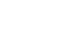

In [23]:
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "UCCSD"
ansatz = UCCSD(qubit_converter,num_particles,num_spin_orbitals)
ansatz.draw("mpl")

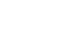

In [24]:
ansatz.decompose().decompose().decompose().draw("mpl")

## Step 5: 量子計算の実行環境を設定

VQEは量子コンピューター上で動作するための情報が必要となります。今回は、ノイズのないシミュレーションを使います。最終的には、（ノイズが多いとはいえ）実際の量子ハードウェアでVQEを動作させ、そう遠くない将来に、古典では達成できない結果を得たいと考えています。

ノイズのないシミュレーションを行うには、以下の手順に従います。

In [25]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))

トライアル状態と実行環境を指定して、VQEの解法(VQEUCCFactory)をセットします。

In [26]:
from qiskit_nature.algorithms import VQEUCCFactory

vqe_solver = VQEUCCFactory(ansatz=ansatz,quantum_instance=quantum_instance)

## Step 6:  VQEの実行

Qiskit Natureは分子の基底状態を計算するためにGroundStateEigensolverというクラスを用意しています。

GroundStateEigensolver オブジェクトを初期化するためには，上述の2つの一般的なアルゴリズムのサブ・コンポーネント，すなわち，マッピング・メソッド（Step 3）とソルビング・メソッド（Step 5）の指定が必要です。テストのために，VQEソルバーに代わるものとして，古典的なソルバーがあります（以下のnumpy_solverを参照）。

In [27]:
from qiskit_nature.algorithms import GroundStateEigensolver

hydrogen_ground_state = GroundStateEigensolver(qubit_converter, vqe_solver)

これでようやく、分子の基底状態のエネルギーを求める準備が整いました。

分子（Step 1）をエンコードしたフェルミオンのハミルトニアン（Step 2）にGroundStateEigensolver を適用します。すると、すでに指定されているマッパーとVQEソルバーが自動的に適用され、基底状態（の近似）が生成されます。

In [28]:
res = hydrogen_ground_state.solve(es_problem)

print(res)

AlgorithmError: 'The number of qubits of the ansatz does not match the operator, and the ansatz does not allow setting the number of qubits using `num_qubits`.'

ご覧のように、電子分布の基底状態のエネルギーを計算しました：-1.85 Hartree

原子核の配置から、原子核エネルギー（Nuclear repulsion energy）も与えられています（古典計算から求められます）。

最後に、量子力学的に計算されたエネルギーと、それと同等の精度（ただし時間はかかる）で古典計算されたエネルギーを比較してみます。

In [ ]:
from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

In [ ]:
hydrogen_ground_state = GroundStateEigensolver(qubit_converter, numpy_solver)
res = hydrogen_ground_state.solve(es_problem)
print(res)

Total ground state energyが、小数点以下において何桁も一致していることから、この特定のハミルトニアンに対して、VQEアルゴリズムが正確に最低のエネルギー解を見つけていることが分かります。

## 原子間距離を変えてエネルギー曲面を求める


## Step 1の改良: 分子を変化させる

Step 1 では、分子の定義を行いました。次に分子の形を変化させる方法を学びます。

*ここでは、私たちが興味を持っている分子の変化（molecular variatio）の種類（すなわち、接近距離を絶対的なステップで変化させること）を指定する方法を紹介します*：

In [ ]:
molecular_variation = Molecule.absolute_stretching

*ここでは、どの原子に変化が適用されるかを指定する方法を説明します。数字はジオメトリーの定義リストの中の原子のインデックスを参照しています。指定されたatom_pairの左側の原子が、右側の原子に近づきます。*

In [ ]:
from functools import partial as apply_variation_to_atom_pair
specific_molecular_variation = apply_variation_to_atom_pair(molecular_variation, atom_pair=(1, 0))

*水素の例で定義を変更する方法を紹介します。*


In [ ]:
hydrogen_molecule_stretchable = Molecule(geometry=
                                 [['H', [0., 0., 0.]],
                                  ['H', [0., 0., 0.735]]],
                                  charge=0, multiplicity=1,
                                  degrees_of_freedom=[specific_molecular_variation])


変化が起きているかどうかをテストしたい場合は、手動で任意の変化量を指定し（Qiskitはこれを*perturbation*（摂動）と呼びます）、新しいジオメトリーがどうなるかを確認することができます：

In [ ]:
hydrogen_molecule_stretchable.perturbations = [0.1]

(上記が指定されていない場合、摂動はゼロとなり、デフォルトでは元のジオメトリになります。)

In [ ]:
hydrogen_molecule_stretchable.geometry

ジオメトリーのリストの2番目の原子（atom_pairの最初に指定されているindex 1のもの）だけが、指定した量だけ他の原子に近づいていることに注目してください。異なる接近距離をスキャンする際には、Qiskitが非常に便利に自動化してくれます。

## Step 6の改良：エネルギー曲面

Step 6では、与えられた分子に対して一度だけ ground_state solver を実行しましたが、上で紹介した仕様を使ってQiskitに分子の形状を変化させるように指示する方法はまだ説明していません。原子核の位置を変えて全エネルギーレベルを比較することで、最もエネルギーが低い原子核の配置を見つける方法です。最も低いエネルギーが「無限大」で**ない**場合、これはエネルギーが最小となる分子の「安定した」結合状態に相当します。このように、エネルギーを原子間距離の関数として求めることは、非常に重要な研究対象です。この関数は **Born-Oppenheimer Potential Energy Surface (BOPES)** と呼ばれています。Qiskit は、形状を変化させ、ground_state solver を繰り返し呼び出すこのプロセスを管理する便利な python クラスを提供します。: **BOPESSampler** です。

水素分子のBOPESSamplerをデモしてみましょう。

*水素分子の例題で再実行する必要があるのは、Steps 1 と2だけです：*

In [ ]:
hydrogen_stretchable_molecular_orbital_maker = ElectronicStructureMoleculeDriver(
    molecule=hydrogen_molecule_stretchable, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)
hydrogen_stretchable_fermionic_hamiltonian = ElectronicStructureProblem(hydrogen_stretchable_molecular_orbital_maker)

*次に、サンプラーの呼び出し方です。：*

In [ ]:
from qiskit_nature.algorithms import BOPESSampler
import numpy as np

energy_surface = BOPESSampler(gss=hydrogen_ground_state, bootstrap=False) # 試行が同じなので、Step4で設定したソルバーで十分です
perturbation_steps = np.linspace(-0.5, 2, 25) # 0.5～2までの25点を等間隔に配置する

energy_surface_result = energy_surface.sample(hydrogen_stretchable_fermionic_hamiltonian, perturbation_steps)

少し実行に時間がかかります。

*次に、有名なエネルギー曲面のプロット作成方法です。：*

In [ ]:
import matplotlib.pyplot as plt

def plot_energy_landscape(energy_surface_result):
    if len(energy_surface_result.points) > 1:
        plt.plot(energy_surface_result.points, energy_surface_result.energies, label="VQE Energy")
        plt.xlabel('Atomic distance Deviation(Angstrom)')
        plt.ylabel('Energy (hartree)')
        plt.legend()
        plt.show()
    else:
        print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
        print("(No need to plot, only one configuration calculated.)")
    
plot_energy_landscape(energy_surface_result)

直感的には、エネルギー地形を、山と谷、そしてボールが転がる台地の隣にあると考えるとよいでしょう（ボールのx座標は、2つの水素原子の間隔に対応します）。ボールが台地を転がる速度が速すぎなければ（右から左へ）、ボールは谷に落ち着くかもしれません。傾きが正（2つの水素原子の間に引力があることを表す）なので、ボールはゆっくりと台地を転がり落ちます。ボールが谷である最小点を通り越すと、山の急な負の傾きの斜面にぶつかり、すぐに転がり戻ってしまいます（水素原子は互いに反発します）。

ここで、最小値がゼロであることに注目してください。これは、水素分子の原子核の位置を、既知の基底状態の位置に定義したからです。

ちなみに、hardware_inspired_trialを使えば、同じようなプロットができたと思いますが、Anzatzが異なる結合長で電子基底状態を均等に捕らえることができないため、凸凹ができたと思われます。


***


# 量子化学でHIVの課題を解く

[IBM Quantum Challenge Africa](https://github.com/qiskit-community/ibm-quantum-challenge-africa-2021) より

<img src="HIV-1_capsid_wikipedia.png"/>

**HIVは、世界的に見ても公衆衛生上、非常に大きな課題となっているウイルスです。** その結果、栄養状態、健康へのアクセス、教育、研究費など、社会のさまざまな側面に影響を与えています。さらに、このウイルスは急速に変異し、異なる株が異なる地域に分布していることも問題です。特に、HIV-1-CとHIV-2の株は、主にアフリカで多く見られます。資金面での格差により、アフリカ株の治療法の研究は他のプログラムに比べて遅れています。アフリカの研究者たちは、この不均衡を解消しようと努力していますが、彼らのツールキットに量子コンピューティングなどの最新技術を加えることを検討すべきです。

**量子コンピューターは、医薬品の設計を飛躍的に向上させます。** 特に、新しい抗レトロウイルス剤を設計するためには、**化学シミュレーション** を行って、抗レトロウイルス剤がウイルスのタンパク質と結合することを確認することが重要です。このようなシミュレーションは、従来のスーパーコンピューターでは難しく、効果がないこともありました。しかし、量子コンピューターを使えば、より正確なシミュレーションが可能になり、よりよい薬剤設計のワークフローが実現すると期待されています。

詳細：抗レトロウイルス薬は、ウイルスのポリタンパク質をより小さなタンパク質に切断してパッケージ化するプロテアーゼと呼ばれるウイルスタンパク質に結合してブロックする薬剤です。プロテアーゼは、化学的なハサミと考えることができます。抗レトロウイルス剤は、ハサミの切断能力を阻害する粘着性の障害物と考えることができます。プロテアーゼが阻害されると、ウイルスは自分自身のコピーを増やすことができません。

ウイルスのプロテアーゼに変異があると、ある抗レトロウイルスの結合傾向が変わります。そのため、変異が起きて抗レトロウイルスがうまく結合できなくなった場合、抗レトロウイルスの分子を調整して再び強く結合できるようにすることが目標となります。

**この課題の主な目的は、抗レトロウイルス分子のトイモデルが、ウイルスのプロテアーゼのトイモデルと結合するかどうかを調べることです。**

この課題では、 **最先端のハイブリッド古典-量子組み込み化学モデリング** を導入し、古典的な近似とより正確な量子計算の間で作業負荷を分割することができます。

最後に、現在の量子コンピューティングに存在するノイズを考慮して最高のパフォーマンスを達成するために、（量子コンピューティングの基本を理解していなくても）量子化学アルゴリズムの設定を微調整する必要があります。

## プロテアーゼ＋抗レトロウイルス薬のマクロ分子の特定

### プロテアーゼ

実際のプロテアーゼ分子は、約100個のアミノ酸からなる2本のポリペプチド鎖で構成されており（2本の鎖は折りたたまれています）、隣り合うアミノ酸同士はいわゆる*ペプチド結合*で結ばれています。

<img src="peptide_bond_wikipedia.png" title="Amino Acid bonding"/>

私たちのプロテアーゼ分子のトイモデルは、このペプチド結合からヒントを得ることにしました。ペプチド結合は、多数のアミノ酸を結合しタンパク質を作る基本的な構造です。ペプチド結合は、一般的なタンパク質の折り畳みや、HIVプロテアーゼの切断能力など、タンパク質の化学的性質を決定する最も重要な要素の1つです。

計算を簡単にするために、分子のO=C-Nの部分に注目してみましょう。分子をできるだけ現実的なものにするために、十分な量の水素原子(H)を残し、また追加します（実際、HCONH$_2$（ホルムアミド）は安定した分子で、イオン性の溶媒でもあるので、イオン結合を「切る」ことができます。)

O=C-Nをプロテアーゼ分子のトイモデルにすること、非常に単純化されてはいますが、それでも生物学的に動機付けされています。
これがそのプロテアーゼのトイモデルです：

<img width=50% src="protease.png"/>

```
"O":  (1.1280, 0.2091, 0.0000)
"N": (-1.1878, 0.1791, 0.0000)
"C": (0.0598, -0.3882, 0.0000)
"H": (-1.3085, 1.1864, 0.0001)
"H": (-2.0305, -0.3861, -0.0001)
"H": (-0.0014, -1.4883, -0.0001)
```

この分子をハサミに見立てて、HIVウイルスのコピーを作る過程で、HIVのマスタータンパク質（Gag-Pol高タンパク質）を切ることができると想像してみてください：

<img width=30% src="carpet_scissors_wikipedia_cropped.png"/>

### 抗レトロウイルス

抗レトロウイルス剤とは、プロテアーゼと結合して、その**切断機構を阻害する**分子のことです。今回のチャレンジでは、1個の炭素原子(C)を抗レトロウイルス分子の代用とします。

<img width=10% src="arv.png"/>

### マクロ分子
2つの分子は私たちの頭の中では別々になっていますが、接近すると、外側の電子がすべての原子の周りに分子軌道を形成して、1つのマクロ分子になります。

水素の例題で説明したように、量子的な電子分布は原子の位置を固定して計算されるので、原子を個別に配置する必要があります。1つ目と2つ目の課題では、プロテアーゼの座標を固定し、抗レトロウイルスの位置だけを直線に沿って変化させます。

その際、任意の点を通り、窒素原子(N)に近づくアプローチの線を選びます。この「ブロック」と呼ばれるアプローチは、ハサミが切るのを邪魔しようとするものです。それが「刺さった」となれば成功で、HIVの複製活動を妨害することに成功したことになります。

## Step 1: マクロ分子の分子定義

抗レトロウイルス剤が「刃」の間にある窒素原子（N）に接近する様子を表現するために、分子定義と分子変化を構築します：
<img width=50% src="arv_approaches_protease.png"/>
 ```
 "C": (-0.1805, 1.3955, 0.0000)
 ```

## 演習
下のセルにあなたの分子を作ってください。分子の名前は必ず`macromolecule`としてください。

In [ ]:
specific_molecular_variation = apply_variation_to_atom_pair(molecular_variation, atom_pair=(?,?)) # この数字を埋めます
#「原子間距離を変えてエネルギー曲面と求める」の章を参考にしてください。
# 6番目の原子"C"の距離を、1番目の原子"N"に対して変化させます。

macromolecule = Molecule(
    geometry=[
        ["O", [1.1280, 0.2091, 0.0000]], #続きを書いてください。ハサミの写真の上に原子の座標が書いてあります。
        ["",[,,]], # この原子名と座標を埋めます
        ["",[,,]], # この原子名と座標を埋めます
        ["",[,,]], # この原子名と座標を埋めます
        ["",[,,]], # この原子名と座標を埋めます
        ["",[,,]], # この原子名と座標を埋めます
        ["C", [-0.1805, 1.3955, 0.0000]],
    ],
    charge=0,
    multiplicity=1,
    degrees_of_freedom=[specific_molecular_variation],
)

## Step 2の改良：量子ワークロードの削減

Step 2では、量子ビット・ハミルトニアンを構築しました。上記のマクロ分子にStep 2以降を適用しようとすると、基底状態計算シミュレーションは失敗します。なぜかというと、電荷を0に指定しましたが、Qiskitは30(=2\*6(2個の炭素)+7(窒素)+8(酸素)+3\*1(3つの水素))個の電子で動作しなければならないことを知っているからです。これは、第二量子化を行うと、60個のスピン軌道に変換されるので、60量子ビットが必要となります。60量子ビットは、私たちが古典シミュレーションできる範囲を超えており、60量子ビット以上のIBM量子システムもありますが、私たちは使えません。したがって、このチャレンジの目的のために、量子ビットの数を減らす必要があります。幸いなことに、この量子ビット数の削減は化学的な観点からも理由があります。正確な化学的結果を得るためには、内殻電子に対して古典的なハートリーフォック近似で十分な場合があります。さらに幸いなことに、Qiskitはつい最近拡張され、特定の電子を量子計算で処理し、残りの電子を古典的に近似するようにユーザーがシームレスに指定できるようになりました。今後、さらに多くの量子ビットが使えるようになったとしても、近未来の量子コンピューターが通常では手の届かない非常に大きな分子に取り組む際に、この機能は非常に有用であることがわかるでしょう。

*そこで次に、Qiskitに指示して、ある数の電子に量子計算処理をさせる方法を紹介します：*

In [ ]:
macro_molecular_orbital_maker = ElectronicStructureMoleculeDriver(
    molecule=macromolecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
split_into_classical_and_quantum =  ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
macro_fermionic_hamiltonian = ElectronicStructureProblem(macro_molecular_orbital_maker, [split_into_classical_and_quantum])

上記のように、Qiskitには**ActiveSpaceTransformer**というクラスがあり、2つの引数を受け取ります。1つ目は、量子計算処理を受けるべき電子の数です（一番外側の電子から順に選んでいきます）。2つ目は、それらの電子が自由に動き回れるようにするための軌道の数です。必要な量子ビット数を決めるのは、この2つ目の数です。（NとCの結合なのでそれぞれ1個ずつ合計2個の電子をアクティブな電子として扱い、それ以外の内殻電子は非アクティブな電子とします。）

## 抗レトロウイルス剤はプロテアーゼと結合し、反応をブロックするでしょうか？

抗レトロウイルス剤のトイモデルとプロテアーゼのトイモデルを使って、反応をシミュレーションします。

In [ ]:
# Step 1 の続き：ドライバーの設定
macro_molecular_orbital_maker = ElectronicStructureMoleculeDriver(
    molecule=macromolecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

# Step 2：電子の運動のエネルギーの式を作る
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
split_into_classical_and_quantum =  ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
macro_fermionic_hamiltonian = ElectronicStructureProblem(macro_molecular_orbital_maker, [split_into_classical_and_quantum])

macro_fermionic_hamiltonian.second_q_ops()

In [ ]:
# Step 3: エネルギー式を量子ゲートに変換
map_fermions_to_qubits = QubitConverter(JordanWignerMapper())

qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

In [ ]:
# Step 4: トライアル状態(Ansatz)をセットする
molecule_info = macro_fermionic_hamiltonian.grouped_property_transformed
particle_number = molecule_info.get_property("ParticleNumber")
num_electrons_spin_up_spin_down = (
    particle_number.num_alpha,
    particle_number.num_beta,
)

from qiskit_nature.circuit.library.initial_states import HartreeFock

initial_state = HartreeFock(
    num_spin_orbitals, num_electrons_spin_up_spin_down, map_fermions_to_qubits
)

chemistry_inspired_trial = UCCSD(
    map_fermions_to_qubits,
    num_electrons_spin_up_spin_down,
    num_spin_orbitals,
    initial_state=initial_state,
)

trial_state = chemistry_inspired_trial

In [ ]:
# Step 5: 量子計算の実行環境を設定
noise_free_quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))
solver = VQEUCCFactory(ansatz=trial_state,quantum_instance=noise_free_quantum_environment)

In [ ]:
# Step 6: VQEの実行
ground_state = GroundStateEigensolver(map_fermions_to_qubits, solver)

In [ ]:
# エネルギー曲面を求める
energy_surface = BOPESSampler(gss=ground_state, bootstrap=False)

perturbation_steps = np.linspace(-0.5, 5, 30)
energy_surface_result = energy_surface.sample(
    macro_fermionic_hamiltonian, perturbation_steps
)

少し実行に時間がかかります。

In [ ]:
plot_energy_landscape(energy_surface_result)

抗レトロウイルス剤がプロテアーゼに接近したときのエネルギー・ランドスケープが得られましたか? 抗レトロウイルス剤はプロテアーゼと結合し、反応をブロックするでしょうか?

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [ ]:
# 演習の解答例
specific_molecular_variation = apply_variation_to_atom_pair(
    molecular_variation, atom_pair=(6, 1)
)
macromolecule = Molecule(
    geometry=[
        ["O", [1.1280, 0.2091, 0.0000]],
        ["N", [-1.1878, 0.1791, 0.0000]],
        ["C", [0.0598, -0.3882, 0.0000]],
        ["H", [-1.3085, 1.1864, 0.0001]],
        ["H", [-2.0305, -0.3861, -0.0001]],
        ["H", [-0.0014, -1.4883, -0.0001]],
        ["C", [-0.1805, 1.3955, 0.0000]],
    ],
    charge=0,
    multiplicity=1,
    degrees_of_freedom=[specific_molecular_variation],
)